In [39]:
import numpy as np
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import svd
from numpy.linalg import lstsq
from scipy.spatial.distance import cdist
%load_ext autoreload
%autoreload 2

def clean_matrix(X, tol=1e-14):
    '''
    
    clean small values in a matrix
    '''            
    X[abs(X)<tol] = 0.
    return X

def calculate_svd_solution(A,b):
    U, S, V = svd(A)
    clean_matrix(U)
    clean_matrix(S)
    clean_matrix(V)
    S_inv = np.zeros((A.T.shape))
    for i in range(min(A.T.shape)):
        if S[i] != 0:
            S_inv[i, i] = 1./S[i]
    x = np.matmul(np.transpose(V), np.matmul(S_inv, np.matmul(np.transpose(U), b)))
    return x

def getZ(X, Y, W):
    return W[0]*X+W[1]*Y+W[2]

def smoothness(best_W_list, X, y):
    p = None
    for W in best_W_list:
        best_W = W["W"]
        if p is None:
            p = np.abs(X.dot(best_W)-y)/np.sqrt(best_W[0]**2+best_W[1]**2+1)
        else:
            p = np.concatenate([p, np.abs(X.dot(best_W)-y)/np.sqrt(best_W[0]**2+best_W[1]**2+1)], axis=1)
    p = np.argmin(p, axis=1)
    mean_dist = []
    for i in range(4):
        ids = (p == i)
        best_W = best_W_list[i]["W"]
        mean = np.mean(np.abs(X[ids].dot(best_W)-y[ids])/np.sqrt(best_W[0]**2+best_W[1]**2+1))
        mean_dist.append(mean)
    
    print(mean_dist)
    print(best_W_list[np.argmin(mean_dist)]["W"])

(-2.6098293909612758,
 3.545005967852316,
 -1.5097781037191793,
 0.7374441271034977)

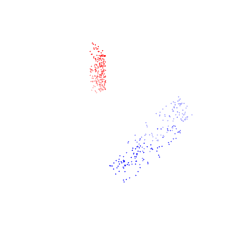

In [102]:
from scipy.stats import ortho_group
R1 = ortho_group.rvs(dim=3)
R2 = ortho_group.rvs(dim=3)
fig = plt.figure()
ax = plt.axes(projection='3d')

clear_table = np.loadtxt("./data/clear_table.txt")
clear_hallway = np.loadtxt("./data/clean_hallway.txt")
selected1 = np.random.choice(clear_table.shape[0], 200, replace=False)
selected2 = np.random.choice(clear_hallway.shape[0], 200, replace=False)
clear_table = clear_table[selected1]
clear_hallway = clear_hallway[selected2]
clear_table_ = clear_table.dot(R1)
clear_hallway_ = clear_hallway.dot(R2)
# X1 = np.concatenate([clear_table[:, [0,2]], np.ones((clear_table.shape[0],1))], axis=1)
# y1 = clear_table[:, [1]]
# X2 = np.concatenate([clear_hallway[:, [0,2]], np.ones((clear_hallway.shape[0],1))], axis=1)
# y2 = clear_hallway[:, [1]]
ax = plt.axes(projection='3d')
ax.scatter3D(clear_table_[:,0], clear_table_[:,2], clear_table_[:,1], c='r', s=0.1, label="object 1")
ax.scatter3D(clear_hallway_[:,0], clear_hallway_[:,2], clear_hallway_[:,1], c='b', s=0.1, label="object 2")
plt.axis("off")
# plt.savefig("proposal_2.png", bbox_inches="tight")

In [103]:
orig = np.concatenate([clear_hallway, clear_table], axis=0)
transformed = np.concatenate([clear_hallway_, clear_table_], axis=0)
# rand1 = np.random.permutation(orig.shape[0])
# rand2 = np.random.permutation(transformed.shape[0])
# orig = orig[rand1]
# transformed = transformed[rand2]

In [104]:
def find_cluster(orig, transformed):
    a = np.expand_dims(orig, axis=1).repeat(orig.shape[0], axis=1)
    b = np.transpose(a, [1,0,2])
    feat1 = np.sqrt(np.sum((a-b)**2, axis=2))
    a = np.expand_dims(transformed, axis=1).repeat(transformed.shape[0], axis=1)
    b = np.transpose(a, [1,0,2])
    feat2 = np.sqrt(np.sum((a-b)**2, axis=2))
#     dm = cdist(feat1, feat2, lambda u, v: len(np.intersect1d(u, v)))
#     match = np.argmax(dm, axis=1)
    point_num = orig.shape[0]
    
    cat = np.ones(point_num)*-1
    
    corres = np.ones(point_num)*-1
    
    unmatched_point = set(np.arange(point_num))
    
    cat_id = 0
    
    while len(unmatched_point)>0:
        while True:
            ref_point_index = np.random.choice(np.array(list(unmatched_point)), 4, replace=False)
            dm = cdist(feat1[ref_point_index], feat2, lambda u, v: len(np.intersect1d(u, v)))
            match = np.argmax(dm, axis=1)
            m = feat1[ref_point_index, :][:, ref_point_index]
            n = feat2[match, :][:, match]
            if np.isclose(m,n).all():
                break
        ref_feat1 = feat1[ref_point_index, :].T  # shape (n,4)
        ref_feat2 = feat2[match, :].T  # shape (n,4)
        
        dist = cdist(ref_feat1, ref_feat2)
        
        in_class = np.min(dist, axis=1) < 1e-9
        matched_point = np.argmin(dist, axis=1)
        cat[in_class] = cat_id
        unmatched_point = unmatched_point - set(in_class.nonzero()[0])
        corres[in_class] = matched_point[in_class]
        
        cat_id += 1
    
    return cat, corres

In [105]:
cat, corres = find_cluster(orig, transformed)

In [27]:
((match - np.arange(400)) == 0).sum()

364

In [99]:
from src.clustering import cluster

In [168]:
result_idx = cluster(orig, transformed, match, thres = 1, iters = 30)

In [169]:
(r_hw, _) = clear_hallway.shape
(r_ct, _) = clear_table.shape
initial_idx = np.concatenate((np.ones((r_hw, 1)), np.zeros((r_ct, 1))), axis=0).astype(int).reshape(-1)

In [170]:
(result_idx == initial_idx).sum() / (r_hw + r_ct)

0.725

In [167]:
print("Hallway {}, Clear Table {}".format(r_hw, r_ct))

Hallway 200, Clear Table 200
